# Alzheimer’s Disease Classification (Demented vs Non-demented)

This notebook provides a **fully reproducible** end-to-end machine learning workflow for binary classification of Alzheimer’s disease status using **demographic, clinical, and MRI-derived features**.

**Target:** `Group` ("Demented" vs "Nondemented").

## Academic / healthcare ML best-practice considerations
- We implement a **group-aware train/test split** (when a subject identifier exists) to reduce optimistic bias due to repeated measures.
- We use **pipelines** and a **ColumnTransformer** to avoid data leakage (fit preprocessing only on training data).
- We report multiple metrics (Accuracy, Precision, Recall, F1) and discrimination performance (ROC-AUC) alongside confusion matrices and ROC curves.

---

## Reproducibility
- Set a fixed random seed.
- Print library versions.
- Use deterministic splits and model settings where applicable.

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    plt.style.use('seaborn-whitegrid')

sns.set_context('notebook')

print('Python:', sys.version.split()[0])
print('scikit-learn:', sklearn.__version__)


Python: 3.13.9
scikit-learn: 1.7.2


## 1) Load dataset

To keep this notebook runnable from scratch in different environments, we attempt to automatically locate a `*.csv` file in the current directory. If you have multiple CSV files, set `DATA_PATH` explicitly.

In [2]:
PROJECT_DIR = Path.cwd()
csv_candidates = sorted(PROJECT_DIR.glob('*.csv'))

if len(csv_candidates) == 0:
    raise FileNotFoundError(
        'No CSV file found in the current directory. '
        'Place the dataset CSV next to this notebook or set DATA_PATH manually.'
    )

DATA_PATH = csv_candidates[0]
print('Using dataset:', DATA_PATH.name)

df = pd.read_csv(DATA_PATH)
df.head()


Using dataset: dataset.csv


,MRI ID,Group,Visit,MR Delay,M/F,Age,EDUC,NIS,MMSE,CDR,eTIV,nWBV,ASF
0,Subject_0001,Nondemented,1,0,M,87,14.0,2.0,27,0.0,1987,0.696,0.883
1,Subject_0001,Nondemented,2,457,M,88,NaN,2.0,30,0.0,2004,0.681,0.876
2,Subject_0002,Demented,1,0,M,75,12.0,NaN,23,0.5,1678,0.736,1.046
3,Subject_0002,Demented,2,560,NaN,76,12.0,3.0,28,0.5,1738,0.713,1.010
4,Subject_0002,Demented,3,1895,M,80,NaN,NaN,22,0.5,1698,0.701,1.034


## 2) Exploratory Data Analysis (EDA)

We examine:
- Dataset structure and data types
- Missing values
- Summary statistics
- Basic distribution plots (including target prevalence)

This step helps identify data quality issues and informs preprocessing decisions.

In [3]:
print('Shape:', df.shape)
display(df.head(10))
print('\nColumns:')
display(pd.DataFrame({'column': df.columns, 'dtype': df.dtypes.astype(str)}))


Shape: (2461, 13)


,MRI ID,Group,Visit,MR Delay,M/F,Age,EDUC,NIS,MMSE,CDR,eTIV,nWBV,ASF
0,Subject_0001,Nondemented,1,0,M,87,14.0,2.0,27,0.0,1987,0.696,0.883
1,Subject_0001,Nondemented,2,457,M,88,NaN,2.0,30,0.0,2004,0.681,0.876
2,Subject_0002,Demented,1,0,M,75,12.0,NaN,23,0.5,1678,0.736,1.046
3,Subject_0002,Demented,2,560,NaN,76,12.0,3.0,28,0.5,1738,0.713,1.010
4,Subject_0002,Demented,3,1895,M,80,NaN,NaN,22,0.5,1698,0.701,1.034
5,Subject_0004,Nondemented,1,0,F,88,18.0,3.0,28,0.0,1215,0.710,1.444
6,Subject_0004,Nondemented,2,538,F,90,18.0,3.0,27,0.0,1200,0.718,1.462
7,Subject_0005,Nondemented,1,0,M,80,12.0,4.0,28,0.0,1689,0.712,1.039
8,Subject_0005,Nondemented,2,1010,M,83,12.0,4.0,29,0.5,1701,0.711,1.032
9,Subject_0005,Nondemented,3,1603,M,85,12.0,4.0,30,0.0,1699,0.705,1.033



Columns:


,column,dtype
MRI ID,MRI ID,object
Group,Group,object
Visit,Visit,int64
MR Delay,MR Delay,int64
M/F,M/F,object
Age,Age,int64
EDUC,EDUC,float64
NIS,NIS,float64
MMSE,MMSE,int64
CDR,CDR,float64


In [4]:
# Data types / non-null counts (compact)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2461 entries, 0 to 2460
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MRI ID    2461 non-null   object 
 1   Group     2461 non-null   object 
 2   Visit     2461 non-null   int64  
 3   MR Delay  2461 non-null   int64  
 4   M/F       2299 non-null   object 
 5   Age       2461 non-null   int64  
 6   EDUC      2351 non-null   float64
 7   NIS       2417 non-null   float64
 8   MMSE      2461 non-null   int64  
 9   CDR       2461 non-null   float64
 10  eTIV      2461 non-null   int64  
 11  nWBV      2461 non-null   float64
 12  ASF       2461 non-null   float64
dtypes: float64(5), int64(5), object(3)
memory usage: 250.1+ KB


,missing_count,missing_pct
M/F,162,6.58
EDUC,110,4.47
NIS,44,1.79


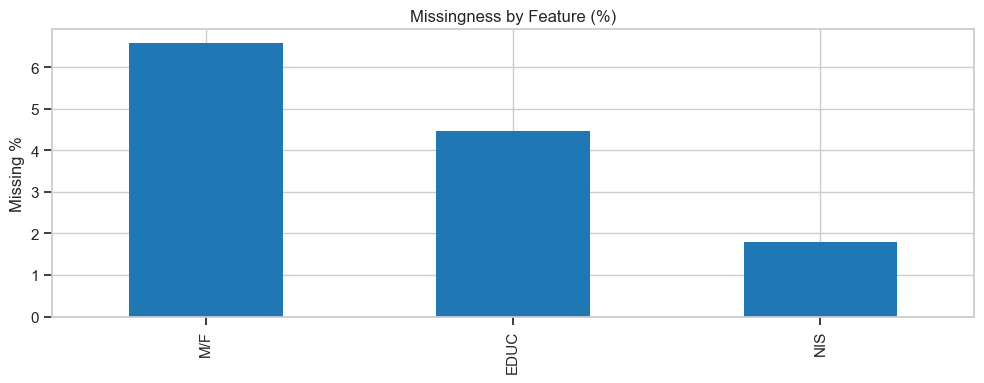

In [5]:
# Missing values count and percentage
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
missing_table = pd.DataFrame({'missing_count': missing, 'missing_pct': missing_pct})
display(missing_table[missing_table.missing_count > 0])

plt.figure(figsize=(10, 4))
missing_pct[missing_pct > 0].plot(kind='bar')
plt.title('Missingness by Feature (%)')
plt.ylabel('Missing %')
plt.tight_layout()
plt.show()


In [6]:
# Summary statistics: numeric and categorical
display(df.describe(include='all').T)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
MRI ID,2461,1150,Subject_1141,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Group,2461,2,Demented,1301,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Visit,2461.0,NaN,NaN,NaN,1.78464,0.896211,1.0,1.0,2.0,2.0,5.0
MR Delay,2461.0,NaN,NaN,NaN,651.345794,806.939448,0.0,0.0,357.0,1152.0,4722.0
M/F,2299,2,F,1344,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,2461.0,NaN,NaN,NaN,78.309224,10.009054,60.0,70.0,78.0,87.0,97.0
EDUC,2351.0,NaN,NaN,NaN,14.706933,4.818099,6.0,11.0,15.0,19.0,23.0
NIS,2417.0,NaN,NaN,NaN,2.48283,1.099657,1.0,2.0,2.0,3.0,5.0
MMSE,2461.0,NaN,NaN,NaN,25.885819,4.651554,4.0,24.0,27.0,29.0,30.0
CDR,2461.0,NaN,NaN,NaN,0.383381,0.50547,0.0,0.0,0.0,0.5,2.0


Target distribution (raw):


Group
Demented       1301
Nondemented    1160
Name: count, dtype: int64

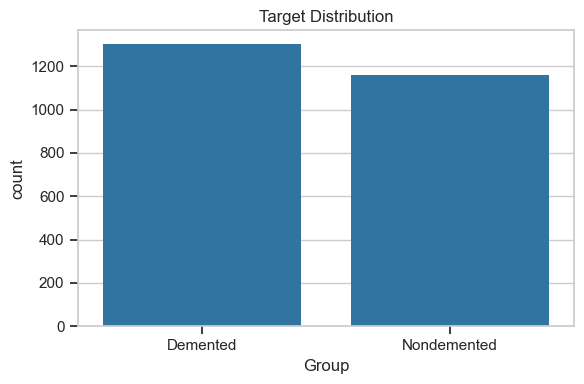

In [7]:
if 'Group' not in df.columns:
    raise KeyError('Expected target column `Group` not found. Available columns: ' + ', '.join(df.columns))

print('Target distribution (raw):')
display(df['Group'].value_counts(dropna=False))

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Group', order=df['Group'].value_counts().index)
plt.title('Target Distribution')
plt.tight_layout()
plt.show()


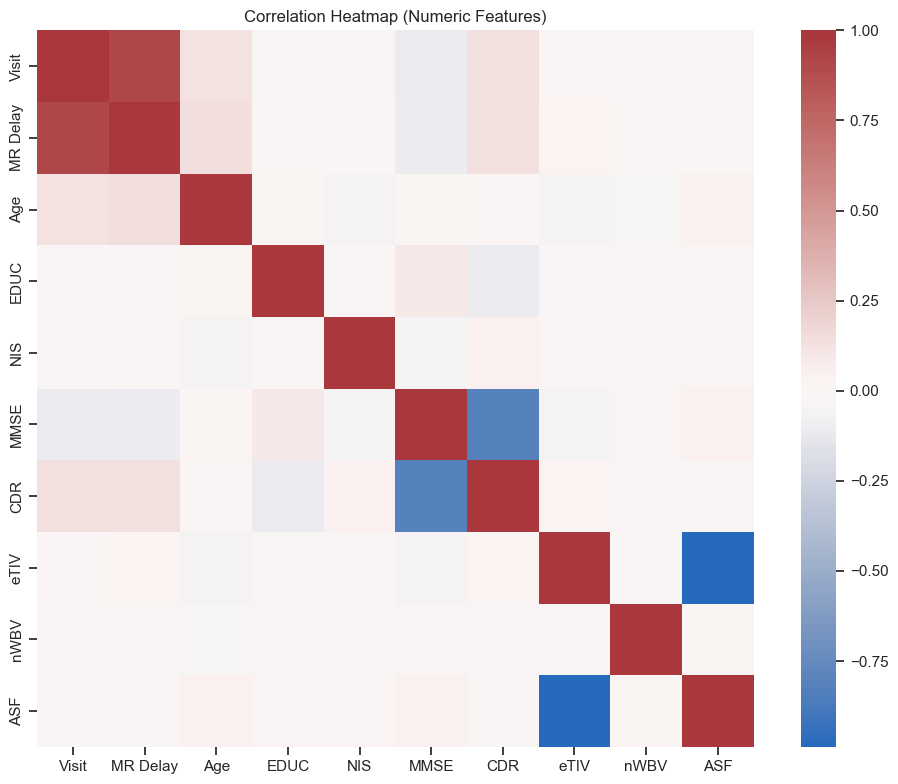

In [8]:
# Correlation heatmap for numeric features (EDA)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr(numeric_only=True)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap='vlag', center=0, square=True)
    plt.title('Correlation Heatmap (Numeric Features)')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric features for correlation heatmap.')


## 3) Define binary classification task

We map the target `Group` to a binary label:
- `Demented` → 1
- `Nondemented` / `Non-demented` → 0

We also remove non-informative identifiers (e.g., subject/MRI identifiers) from the feature set to prevent leakage.

In [9]:
target_col = 'Group'
id_like_cols = [
    'MRI ID',
    'MR ID',
    'Subject',
    'Subject ID',
    'PatientID',
    'Patient ID',
    'ID',
    'RecordID',
]

group_col = 'MRI ID' if 'MRI ID' in df.columns else None
groups = df[group_col].copy() if group_col is not None else None

# Normalize target labels robustly
y_raw = df[target_col].astype(str).str.strip().str.lower()
label_map = {
    'demented': 1,
    'nondemented': 0,
    'non-demented': 0,
    'non demented': 0,
}

if not set(y_raw.unique()).issubset(set(label_map.keys())):
    raise ValueError(
        'Unexpected target labels in `Group`. '
        f'Observed: {sorted(y_raw.unique())}. '
        f'Expected subset of: {sorted(label_map.keys())}.'
    )

y = y_raw.map(label_map).astype(int)

cols_to_drop = [c for c in id_like_cols if c in df.columns]
X = df.drop(columns=[target_col] + cols_to_drop)

print('Dropped identifier columns:', cols_to_drop)
print('Feature matrix shape:', X.shape)
print('Positive class prevalence (Demented=1):', y.mean().round(3))


Dropped identifier columns: ['MRI ID']
Feature matrix shape: (2461, 11)
Positive class prevalence (Demented=1): 0.529


## 4) Train/Test split

Healthcare datasets frequently contain repeated measures per subject (e.g., multiple visits).

If a subject identifier exists (here: `MRI ID`), we perform a **group-aware split** so that the same subject does not appear in both train and test sets. This reduces leakage and yields a more realistic evaluation.

In [10]:
TEST_SIZE = 0.2

if groups is not None:
    splitter = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    train_idx, test_idx = next(splitter.split(X, y, groups=groups))
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()
    print(f'Group-aware split using `{group_col}`:')
    print('  Train subjects:', groups.iloc[train_idx].nunique())
    print('  Test subjects :', groups.iloc[test_idx].nunique())
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    print('Stratified random split (no group column found).')

print('Train size:', X_train.shape, 'Test size:', X_test.shape)
print('Train prevalence:', y_train.mean().round(3), 'Test prevalence:', y_test.mean().round(3))


Group-aware split using `MRI ID`:
  Train subjects: 920
  Test subjects : 230
Train size: (1965, 11) Test size: (496, 11)
Train prevalence: 0.528 Test prevalence: 0.532


## 5) Preprocessing pipeline

We build an explicit preprocessing pipeline:
- **Missing values**: median for numeric, most frequent for categorical
- **Categorical encoding**: one-hot encoding
- **Scaling**: standardization for numeric features (important for LR/SVM/KNN)

Using `Pipeline` + `ColumnTransformer` ensures preprocessing is learned **only from training data**, preventing leakage.

In [11]:
categorical_features = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
numeric_features = [c for c in X_train.columns if c not in categorical_features]

print('Categorical features:', categorical_features)
print('Numeric features:', numeric_features)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

# scikit-learn changed OneHotEncoder's sparsity parameter name.
# This try/except keeps the notebook runnable across versions commonly found in teaching labs.
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', ohe),
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='drop'
)


Categorical features: ['M/F']
Numeric features: ['Visit', 'MR Delay', 'Age', 'EDUC', 'NIS', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']


## 6) Train and evaluate models

We train and evaluate four classical baselines commonly used for structured healthcare data:
- Logistic Regression
- Random Forest
- Support Vector Machine (RBF)
- K-Nearest Neighbors

For potential class imbalance, we use `class_weight='balanced'` where supported.

In [12]:
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=2000,
        solver='liblinear',
        class_weight='balanced',
        random_state=RANDOM_STATE,
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=500,
        random_state=RANDOM_STATE,
        class_weight='balanced',
        n_jobs=-1,
    ),
    'SVM (RBF)': SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        probability=True,
        class_weight='balanced',
        random_state=RANDOM_STATE,
    ),
    'KNN': KNeighborsClassifier(
        n_neighbors=7,
        weights='distance',
    ),
}

pipelines = {
    name: Pipeline(steps=[('preprocess', preprocess), ('model', model)])
    for name, model in models.items()
}

def get_score_vector(fitted_pipeline, X_input):
    """
    Returns a continuous score for ROC-AUC / ROC curve when possible.
    Preference: predict_proba -> decision_function.
    """
    if hasattr(fitted_pipeline, 'predict_proba'):
        proba = fitted_pipeline.predict_proba(X_input)
        return proba[:, 1]
    if hasattr(fitted_pipeline, 'decision_function'):
        return fitted_pipeline.decision_function(X_input)
    return None

results = []
fitted = {}

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    fitted[name] = pipe

    y_pred = pipe.predict(X_test)
    y_score = get_score_vector(pipe, X_test)

    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'ROC_AUC': roc_auc_score(y_test, y_score) if y_score is not None else np.nan,
    }
    results.append(metrics)

pd.DataFrame(results)


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression,0.919355,0.982759,0.863636,0.919355,0.931900
1,Random Forest,0.911290,0.966102,0.863636,0.912000,0.929336
2,SVM (RBF),0.919355,0.982759,0.863636,0.919355,0.923736
3,KNN,0.854839,0.975248,0.746212,0.845494,0.918201


## 7) Evaluation: confusion matrices

Confusion matrices provide an interpretable summary of errors. In clinical contexts, **false negatives** (missed dementia cases) can be particularly costly, so we examine recall and false negative counts closely.

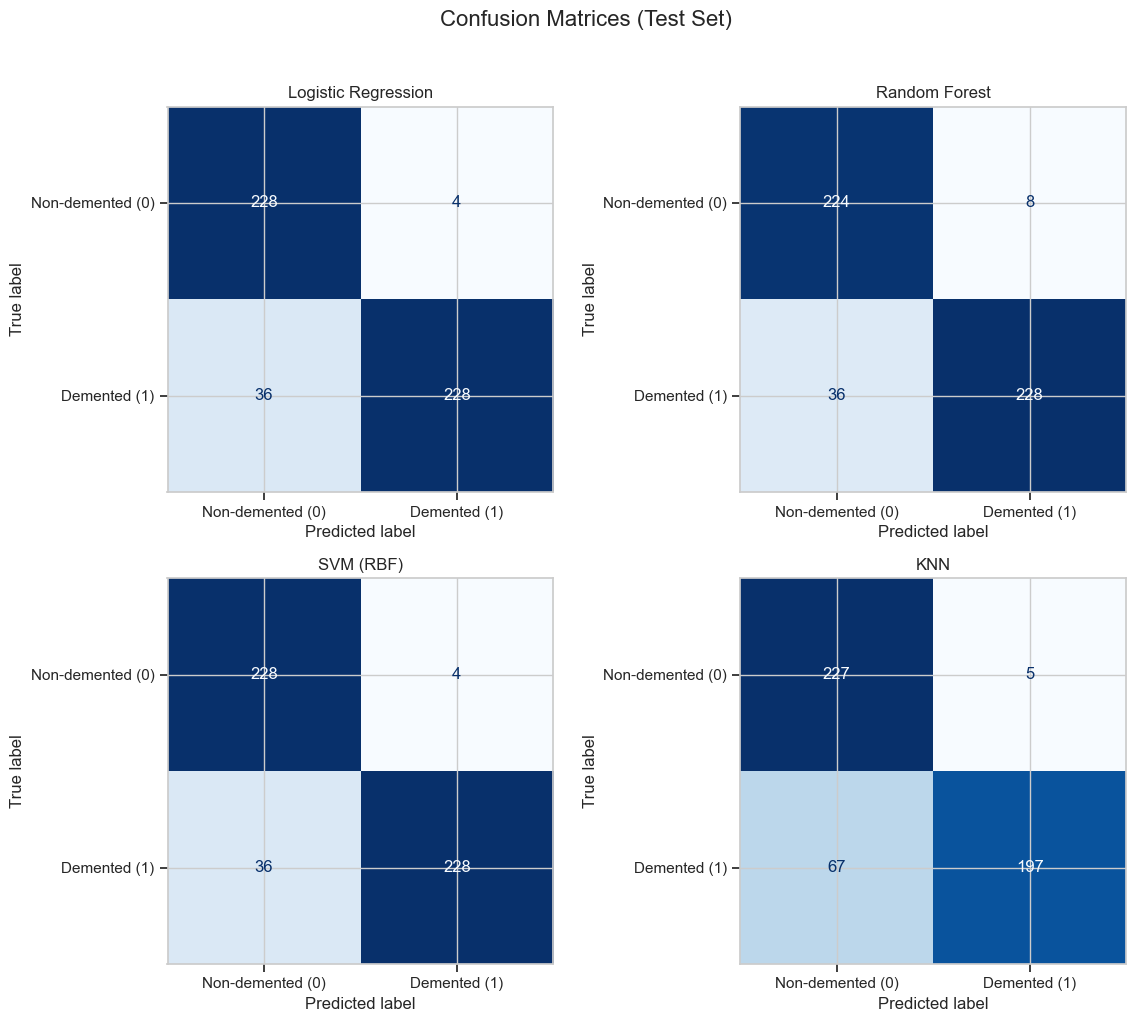

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for ax, (name, pipe) in zip(axes, fitted.items()):
    y_pred = pipe.predict(X_test)
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=['Non-demented (0)', 'Demented (1)'],
        cmap='Blues',
        ax=ax,
        colorbar=False,
    )
    ax.set_title(name)

plt.suptitle('Confusion Matrices (Test Set)', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


## 8) Evaluation: ROC curves and AUC

ROC curves visualize the sensitivity/specificity trade-off across thresholds.
We plot ROC curves for all models on the same axes for a direct comparison.

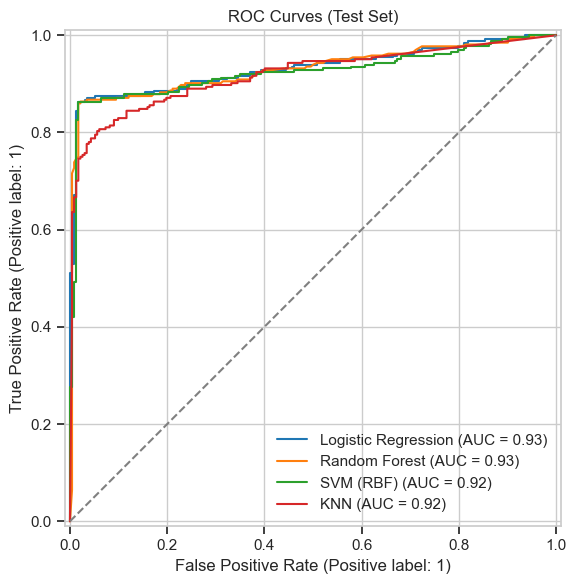

In [14]:
plt.figure(figsize=(8, 6))
ax = plt.gca()

for name, pipe in fitted.items():
    RocCurveDisplay.from_estimator(pipe, X_test, y_test, ax=ax, name=name)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance')
plt.title('ROC Curves (Test Set)')
plt.tight_layout()
plt.show()


## 9) Model comparison table

We summarize model performance in a single table.

**Interpretation guidance (academic):**
- **Accuracy** can be misleading under class imbalance.
- **Recall** (sensitivity) for the demented class is critical for screening settings.
- **Precision** relates to false positives (unnecessary follow-up).
- **F1-score** balances precision and recall.
- **ROC-AUC** measures ranking performance independent of a single threshold.

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression,0.919,0.983,0.864,0.919,0.932
1,Random Forest,0.911,0.966,0.864,0.912,0.929
2,SVM (RBF),0.919,0.983,0.864,0.919,0.924
3,KNN,0.855,0.975,0.746,0.845,0.918


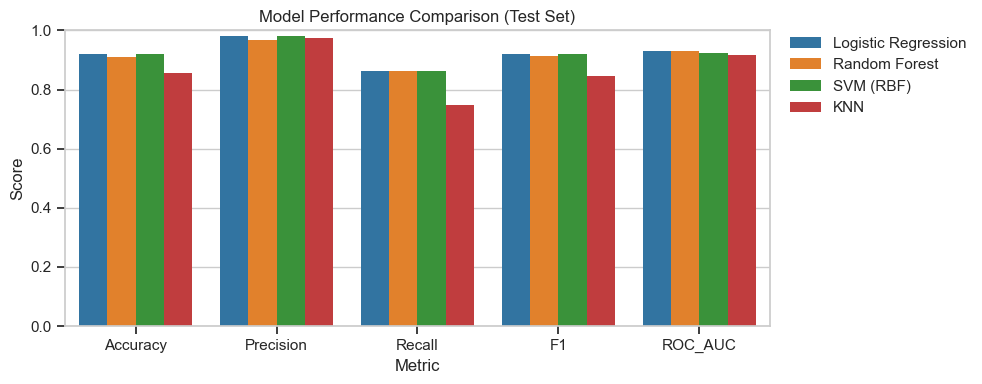

In [15]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['ROC_AUC', 'F1'], ascending=False)
display(results_df.style.format({
    'Accuracy': '{:.3f}',
    'Precision': '{:.3f}',
    'Recall': '{:.3f}',
    'F1': '{:.3f}',
    'ROC_AUC': '{:.3f}',
}))

plt.figure(figsize=(10, 4))
melted = results_df.melt(id_vars='Model', value_vars=['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'], var_name='Metric', value_name='Score')
sns.barplot(data=melted, x='Metric', y='Score', hue='Model')
plt.title('Model Performance Comparison (Test Set)')
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()


## 10) Notes for academic reporting

For an academic assessment, consider discussing:
- Potential sources of bias (e.g., repeated visits, demographic confounding).
- Class imbalance and metric selection.
- Generalization: performance on a held-out test set vs. cross-validation.
- Clinical implications: prioritizing sensitivity vs. specificity.

If you want, I can extend this notebook with:
- Group-aware cross-validation
- Calibration plots (reliability)
- Feature importance (RF) and coefficients (LR) with confidence intervals
- Threshold tuning to meet a target sensitivity